In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [282]:
class CRP:
    
    def __init__(self, gamma, max_depth, max_width = 2):
        self.gamma = gamma
        self.max_depth = max_depth
        self.max_width = max_width
        self.tables = []
        self.n = 0
    
    def _nested_sum(self, table):
        total = 0
        if not isinstance(table, list):
            return table
        for i in table:
            if isinstance(i, list):
                total += self._nested_sum(i)
            else:
                total += i
        return total
        
    def _seat(self, table, depth):
        
        is_leaf= depth+1 >= self.max_depth
               
        n_seated = np.array([self._nested_sum(t) for t in table])
        n_total = n_seated.sum() + 1
        
        if n_total == 0:
            selected_table = 0
        else:
            gamma = self.gamma
            if len(table) == self.max_width:
                gamma = 0
                
            denom = gamma + n_total -1
            p_table = np.concatenate([n_seated/denom, [gamma/denom]], axis = -1)
                        
            selected_table = np.random.choice(range(len(table)+1), p = p_table)
        
        recurse_table = []
        if selected_table == len(table):
                        
            if is_leaf:
                table.append(1)
                return [selected_table]
            else:
                table.append(recurse_table)
                return [selected_table, *self._seat(recurse_table, depth+1)]
                     
        else:
            recurse_table = table[selected_table]
        
            if is_leaf:
                return [selected_table]
            else:
                return [selected_table, *self._seat(recurse_table, depth+1)]
    
    def new_customer(self):
        return [0,*self._seat(self.tables, 1)]
    
    

In [1231]:
def stick_break(betas):
    
    beta_cumprod = np.concatenate([[1], np.cumprod(1 - betas)])
    betas = np.concatenate([betas, [1]])

    return betas * beta_cumprod


def GEM(time, pi, T):
    
    betas = np.random.beta(m*pi, (1-m)*pi, size = T-1)
    #print(betas)
    return stick_break(
        betas
    )

In [1232]:
def generate_branching_process(
    n_cells = 1000,
    gamma = 0.1,
    max_depth = 3,
    max_width = 2,
    branch_times = [0., 0.5, 1.],
    ptime_alpha = 1.,
    ptime_beta = 1.,
    sigmoid_approach = False,
    simplex_aggressive = 10
):
    assert(len(branch_times) == (max_depth +1))
    branch_times = np.array(branch_times)
    crp = CRP(gamma, max_depth, max_width=max_width)
    
    cells = []
    for cell in range(n_cells):
        
        pseudotime = np.random.beta(ptime_alpha, ptime_beta)
        path = crp.new_customer()
                        
        level = np.argmin(pseudotime > branch_times) - 1
        progress = (pseudotime - branch_times[level])/(branch_times[level+1] - branch_times[level])
        
        if sigmoid_approach:
            x = simplex_aggressive*(progress - 0.5)
            progress = 1/(1+np.exp(-x))
            
            
        mixing = np.concatenate([np.zeros(level), 
                                 [1-progress, progress],
                                np.zeros(len(path) - level - 1)])
        
        cells.append((pseudotime, path,mixing))
        
    return cells

In [1258]:
max_width = 2
max_depth = 2

cells = generate_branching_process(max_width=max_width, branch_times=[0, 0.5, 1], max_depth=max_depth,
                                  sigmoid_approach=True, ptime_beta=1, gamma = 0.1)



In [1259]:
pseudotime, components, proportions = list(zip(*cells))

def get_idx_from_path(path):
    idx = [1]
    for p in path[1:]:
        idx.append(2*idx[-1] + p)
        
    return idx

components = np.array([[0, *get_idx_from_path(p)] for p in components])
proportions = np.array(proportions)

pseudotime = np.array(pseudotime)
proportions = proportions[:,:,np.newaxis]

states = np.array([
    [1., 0., 0.],
    [0.33,0.33,0.33],
    [0.,1.,0.],
    [0.,0.,1.]
])

simplex = (states[components.astype(int)] * proportions).sum(1)

a, b, c = simplex[:,0], simplex[:,1], simplex[:,2]

# translate the data to cartesian corrds
x = 0.5 * ( 2.*b+c ) / ( a+b+c )
y = 0.5*np.sqrt(3) * c / (a+b+c)

/Users/alynch/opt/miniconda3/envs/mirarep/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


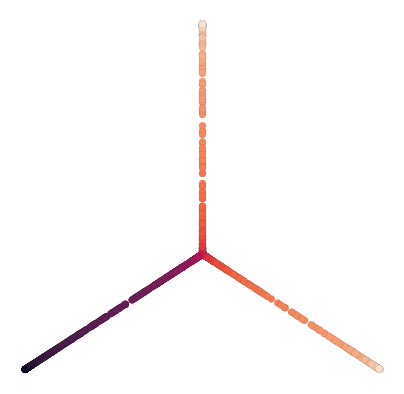

In [1268]:
fig, ax = plt.subplots(1,1,figsize=(7,7))
sns.scatterplot(x,y, hue=np.array(pseudotime), s= 50, ax = ax, legend=False,
               palette='rocket', edgecolor = 'black', linewidth = 0.05)
plt.axis('off')
plt.show()

In [994]:
!cp /Users/alynch/Downloads/pbmc_granulocyte_sorted_10k_filtered_feature_bc_matrix.h5 ./data/

In [997]:
import anndata
import scanpy as sc

In [1004]:
rna_data = sc.read_10x_h5('data/pbmc_granulocyte_sorted_10k_filtered_feature_bc_matrix.h5',
                         gex_only = True)
rna_data.var_names_make_unique()

sc.pp.filter_genes(rna_data, min_cells =30)

rna_data.raw = rna_data
sc.pp.normalize_total(rna_data, target_sum=1e4)
sc.pp.log1p(rna_data)
sc.pp.highly_variable_genes(rna_data)
sc.tl.pca(rna_data)
sc.pp.neighbors(rna_data)
sc.tl.umap(rna_data, min_dist = 0.1)

rna_data.layers['counts'] = rna_data.raw.to_adata().X.copy()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [1067]:
import mira

In [1068]:
mira.utils.wide_view()

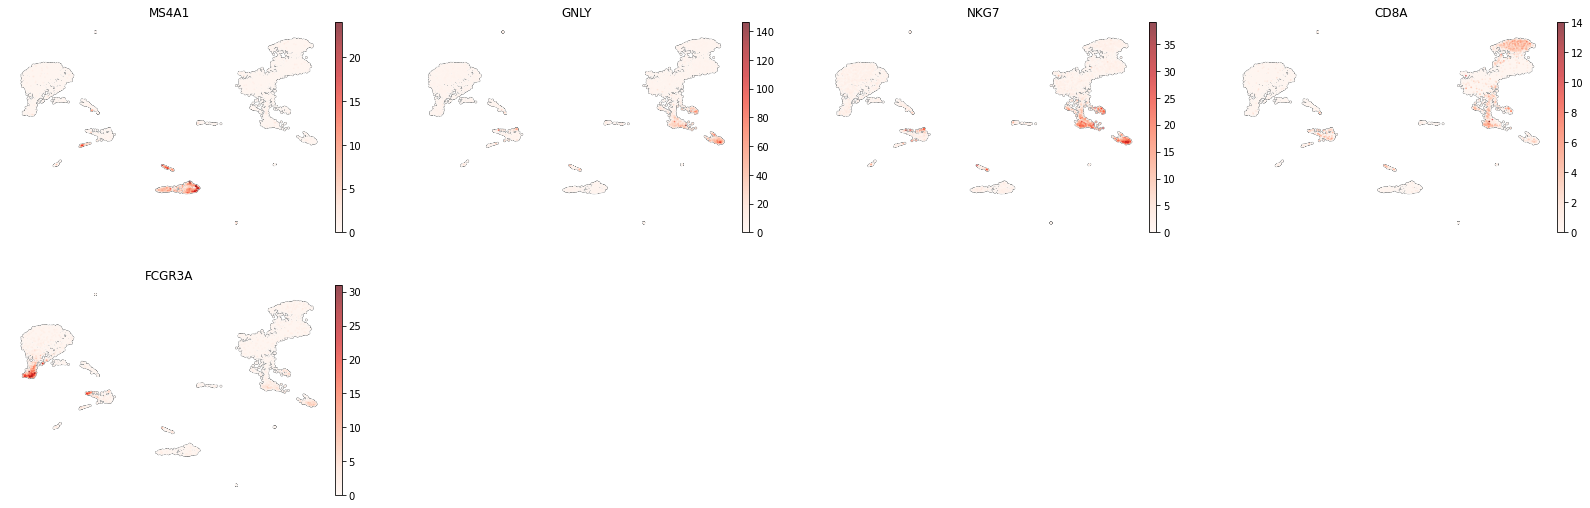

In [1076]:
sc.pl.umap(rna_data, color = ['MS4A1','GNLY','NKG7','CD8A','FCGR3A'], color_map='Reds', frameon=False, add_outline=True,
          outline_color=('grey','white'))

/Users/alynch/opt/miniconda3/envs/mirarep/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:ylabel='count'>

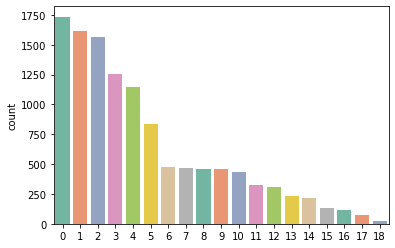

In [1294]:
rna_data.obs['leiden'] = rna_data.obs.leiden.astype(str)
sns.countplot(rna_data.obs.leiden.values, palette='Set2', order=map(str, range(19)))

In [1052]:
sc.pp.calculate_qc_metrics(rna_data, inplace=True, log1p=True)

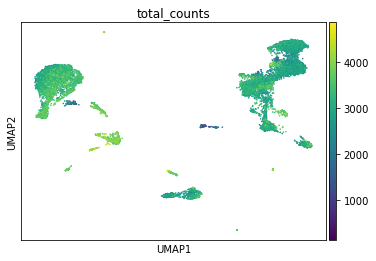

In [1053]:
sc.pl.umap(rna_data, color = 'total_counts')

In [1210]:
cell_states = ['2','3','8']

In [1211]:
raw_data = rna_data.raw.to_adata()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [1212]:
raw_data.var_names_make_unique()

In [1213]:
rna_data.layers['counts'] = raw_data[:, rna_data.var_names].X

In [1214]:
from scipy.stats import multivariate_hypergeom, gamma
from tqdm.notebook import tqdm
import pandas as pd
from scipy import sparse

In [1269]:
def prepare_adata(adata, cell_states, 
                  cell_state_col = 'leiden',
                 counts_layer = 'counts'):
    
    return {
        c : (adata[adata.obs[cell_state_col] == c].layers[counts_layer].tocsr(), 
             np.array(adata[adata.obs[cell_state_col] == c].layers[counts_layer].sum(-1)).reshape(-1))
        for c in cell_states
    }

def sample_proportions(state_counts, mixing_weights, rd_distribution):
    
    read_depth = rd_distribution.rvs()
    
    found_cells = False
    while not found_cells:
        samples = [np.random.choice(X[0].shape[0]) for X in state_counts.values()]
        sample_counts = [X[1][sample] for X, sample in zip(state_counts.values(), samples)]
        
        found_cells = all([count > (read_depth * mix) for mix, count in zip(mixing_weights, sample_counts)])
        
    cell_samples = [X[0][sample].astype(int) for X, sample in zip(state_counts.values(), samples)]
    
    
    def geom_sample_sparse_array(arr, n_samples):
        
        subsampled_reads = multivariate_hypergeom(arr.data, n_samples).rvs()
        
        return sparse.csr_matrix((subsampled_reads.reshape(-1), arr.indices, arr.indptr), shape = arr.shape)
        
    mixed_cell = np.array(sparse.vstack([
        geom_sample_sparse_array(feature_counts, int(read_depth * m))
        for feature_counts, m in zip(cell_samples, mixing_weights)
    ]).sum(0)).reshape(-1)
    
    return mixed_cell

# Try with PBMCs

In [ ]:
fake_cells = np.vstack([
    sample_proportions(state_counts, [0.33,0.33,0.33], gamma(358.7373522936841, -9475.454714712116, 34.5479138119321))
    for i in tqdm(range(100))
])

In [ ]:
rna_data.var_names_make_unique()

In [ ]:
fake = anndata.AnnData(
    X = sparse.csr_matrix(fake_cells), obs = pd.DataFrame(index = range(len(fake_cells))),
    var = pd.DataFrame(index = rna_data.var_names.copy())
)

In [ ]:
concat = anndata.concat([rna_data, fake], axis = 0)

In [ ]:
sc.tl.pca(concat)

sc.pp.neighbors(concat)
sc.tl.umap(concat, min_dist = 0.1)

In [ ]:
concat.obs['fake'] = (len(concat) - np.arange(len(concat)) < 100).astype(str)

/Users/alynch/opt/miniconda3/envs/mirarep/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'fake' as categorical


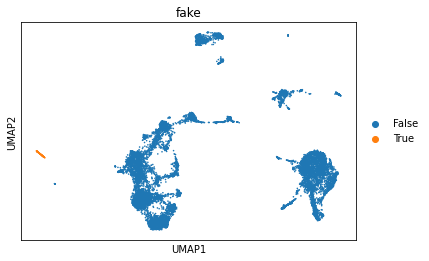

In [1229]:
sc.pl.umap(concat, color = 'fake')

# Generate a fake lineage

In [1271]:
state_counts = prepare_adata(rna_data, ['2','3','8'], counts_layer='counts')

In [1272]:
rd_distribution = gamma(358.7373522936841, -9475.454714712116, 34.5479138119321)

In [1273]:
fake_cells = []
for mix in tqdm(simplex, desc = 'Generating test lineage'):
    fake_cells.append(
        sample_proportions(state_counts, mix, rd_distribution)
    )

Generating test lineage:   0%|          | 0/1000 [00:00<?, ?it/s]

In [1274]:
fake = anndata.AnnData(
    X = sparse.csr_matrix(fake_cells), obs = pd.DataFrame(index = range(len(fake_cells))),
    var = pd.DataFrame(index = rna_data.var_names.copy())
)

/Users/alynch/opt/miniconda3/envs/mirarep/lib/python3.7/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [1275]:
fake.layers['counts'] = fake.X.copy()

sc.pp.normalize_total(fake, target_sum=1e4)
sc.pp.log1p(fake)

sc.pp.highly_variable_genes(fake)
sc.tl.pca(fake)
sc.pp.neighbors(fake, n_pcs = 10)
sc.tl.umap(fake, min_dist = 0.1)

fake.obs[['prop_' + str(i) for i in range(3)]] = simplex

In [1283]:
fake.obs['pseudotime'] = pseudotime

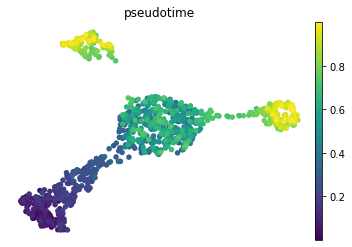

In [1286]:
sc.pl.umap(fake, color = 'pseudotime', frameon=False)

# Putting it all together

In [1]:
import mira
import scanpy as sc
import anndata
from scipy.stats import multivariate_hypergeom, gamma
from tqdm.notebook import tqdm
import pandas as pd
from scipy import sparse
from scipy.stats import multivariate_hypergeom, gamma
from tqdm.notebook import tqdm
import pandas as pd
from scipy import sparse
from functools import partial
import numpy as np
from joblib.parallel import Parallel, delayed
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
rna_data = sc.read_10x_h5('data/pbmc_granulocyte_sorted_10k_filtered_feature_bc_matrix.h5',
                         gex_only = True)
rna_data.var_names_make_unique()

sc.pp.filter_genes(rna_data, min_cells =30)

rna_data.raw = rna_data
sc.pp.normalize_total(rna_data, target_sum=1e4)
sc.pp.log1p(rna_data)
sc.pp.highly_variable_genes(rna_data)
sc.tl.pca(rna_data)
sc.pp.neighbors(rna_data)
rna_data.layers['counts'] = rna_data.raw.to_adata().X.copy()

sc.tl.leiden(rna_data, resolution=1)
rna_data.obs['cell_groups'] = rna_data.obs.leiden.map({'3' : 'A','4' : 'A', '2' : 'B', '8' : 'C'})

sc.tl.umap(rna_data, min_dist = 0.1)

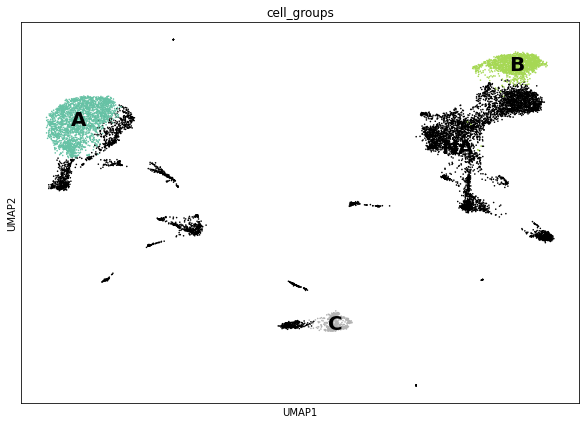

In [22]:
fig, ax = plt.subplots(1,1,figsize=(10,7))
sc.pl.umap(rna_data, color = 'cell_groups', legend_loc='on data', ax = ax,
          legend_fontsize=20, palette='Set2', na_color='black')

In [3]:
atac_data = sc.read_10x_h5('data/pbmc_granulocyte_sorted_10k_filtered_feature_bc_matrix.h5',
                         gex_only = False)

atac_data = atac_data[:, atac_data.var.feature_types == 'Peaks']
atac_data = atac_data[rna_data.obs_names]

atac_data.obs['leiden'] = rna_data.obs.leiden.values.copy()

atac_data.layers['counts'] = atac_data.X

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.


In [4]:
class CRP:
    
    def __init__(self, gamma, max_depth, max_width = 2):
        self.gamma = gamma
        self.max_depth = max_depth
        self.max_width = max_width
        self.tables = []
        self.n = 0
    
    def _nested_sum(self, table):
        total = 0
        if not isinstance(table, list):
            return table
        for i in table:
            if isinstance(i, list):
                total += self._nested_sum(i)
            else:
                total += i
        return total
        
    def _seat(self, table, depth):
        
        is_leaf= depth+1 >= self.max_depth
               
        n_seated = np.array([self._nested_sum(t) for t in table])
        n_total = n_seated.sum() + 1
        
        if n_total == 0:
            selected_table = 0
        else:
            gamma = self.gamma
            if len(table) == self.max_width:
                gamma = 0
                
            denom = gamma + n_total -1
            p_table = np.concatenate([n_seated/denom, [gamma/denom]], axis = -1)
                        
            selected_table = np.random.choice(range(len(table)+1), p = p_table)
        
        recurse_table = []
        if selected_table == len(table):
                        
            if is_leaf:
                table.append(1)
                return [selected_table]
            else:
                table.append(recurse_table)
                return [selected_table, *self._seat(recurse_table, depth+1)]
                     
        else:
            recurse_table = table[selected_table]
        
            if is_leaf:
                return [selected_table]
            else:
                return [selected_table, *self._seat(recurse_table, depth+1)]
    
    def new_customer(self):
        return [0,*self._seat(self.tables, 1)]
    
    
def sigmoid(x):
    return 1/(1+np.exp(-x))
    
    
def generate_branching_process(
    branch_times,
    n_cells = 1000,
    gamma = 0.1,
    max_depth = 2,
    max_width = 2,
    ptime_alpha = 1.,
    ptime_beta = 1.,
    sigmoid_approach = True,
    sigmoid_aggression = 5,
):
    assert(len(branch_times) == (max_depth +1))
    branch_times = np.array(branch_times)
    crp = CRP(gamma, max_depth, max_width=max_width)
    
    min_sigmoid, max_sigmoid = sigmoid(-0.5 * sigmoid_aggression), sigmoid(0.5 * sigmoid_aggression)
    
    cells = []
    for cell in range(n_cells):
        
        pseudotime = np.random.beta(ptime_alpha, ptime_beta)
        path = crp.new_customer()
                        
        level = np.argmin(pseudotime > branch_times) - 1
        progress = (pseudotime - branch_times[level])/(branch_times[level+1] - branch_times[level])
        
        
        if sigmoid_approach:
            #yeah = progress
            x = sigmoid_aggression*(progress - 0.5)
            progress = (sigmoid(x) - min_sigmoid)/(max_sigmoid - min_sigmoid)
            #print(yeah, progress)
            
            
        mixing = np.concatenate([np.zeros(level), 
                                 [1-progress, progress],
                                np.zeros(len(path) - level - 1)])
        
        cells.append((pseudotime, path, mixing))
        
    return list(
        map(np.array, list(zip(*cells)))
    )


def get_idx_from_path(path):
    idx = [1]
    for p in path[1:]:
        idx.append(2*idx[-1] + p)
        
    return idx


def prepare_adata(adata, cell_states, 
                  cell_state_col = 'leiden',
                 counts_layer = 'counts'):
    
    return {
        c : (adata[adata.obs[cell_state_col] == c].layers[counts_layer].tocsr(), 
             np.array(adata[adata.obs[cell_state_col] == c].layers[counts_layer].sum(-1)).reshape(-1))
        for c in cell_states
    }


def validate_cells(samples, state_counts, read_depth, mixing_weights):
    sample_counts = [X[1][sample] for X, sample in zip(state_counts.values(), samples)]
    assert all([count > int(read_depth * mix) for mix, count in zip(mixing_weights, sample_counts)])


def mix_cells(samples, state_counts, read_depth, mixing_weights):
    
    cell_samples = [X[0][sample].astype(int) for X, sample in zip(state_counts.values(), samples)]
    
    def geom_sample_sparse_array(arr, n_samples):
        
        subsampled_reads = multivariate_hypergeom(arr.data, n_samples).rvs()
        return sparse.csr_matrix((subsampled_reads.reshape(-1), arr.indices, arr.indptr), shape = arr.shape)
        
    mixed_cell = sparse.csr_matrix(sparse.vstack([
        geom_sample_sparse_array(feature_counts, int(read_depth * m))
        for feature_counts, m in zip(cell_samples, mixing_weights)
    ]).sum(0))
    
    return mixed_cell


def sample_proportions(*,
    state_counts_rna, state_counts_atac, mixing_weights,
    rna_rd_distribution, atac_rd_distribution):
    
    rna_read_depth = rna_rd_distribution.rvs()
    atac_read_depth = atac_rd_distribution.rvs()
    
    rna_params = state_counts_rna, rna_read_depth, mixing_weights
    atac_params = state_counts_atac, atac_read_depth, mixing_weights
    
    found_cells = False
    while not found_cells:
        
        samples = [np.random.choice(X[0].shape[0]) for X in state_counts_rna.values()]
        
        try:
            validate_cells(samples, *rna_params)
            validate_cells(samples, *atac_params)
            found_cells = True
        except AssertionError:
            pass
        
            
    frankencell = mix_cells(samples, *rna_params), mix_cells(samples, *atac_params)
    
    return frankencell


def get_simplex_layout(mixing_weights):
    
    a, b, c = mixing_weights[:,0], mixing_weights[:,1], mixing_weights[:,2]

    # translate the data to cartesian corrds
    x = 0.5 * ( 2.*b+c ) / ( a+b+c )
    y = 0.5*np.sqrt(3) * c / (a+b+c)
    
    return x,y


def make_franken_cells(
    seed = 1776,
    n_cells = 1000,
    gamma = 0.1,
    max_depth = 2,
    max_width = 2,
    ptime_alpha = 1.,
    ptime_beta = 1.,
    sigmoid_approach = True,
    sigmoid_aggression = 5,
    cell_state_col = 'leiden',
    rna_counts_layer = None,
    atac_counts_layer = None,
    generate_cells = True,
    n_jobs = 1,*,
    branch_times,
    state_compositions,
    pure_states,
    rna_read_depth_distribution,
    atac_read_depth_distribution,
    rna_adata,
    atac_adata,
):
    np.random.seed(seed=seed)
    
    assert((rna_adata.obs_names == atac_data.obs_names).all())
    assert((rna_adata.obs[cell_state_col] == atac_data.obs[cell_state_col]).all())
        
    pseudotime, paths, transition_mixing = generate_branching_process(
        branch_times,
        gamma = gamma, max_depth = max_depth, max_width = max_width,
        ptime_alpha= ptime_alpha, ptime_beta=ptime_beta,
        sigmoid_approach=sigmoid_approach, sigmoid_aggression=sigmoid_aggression,
        n_cells = n_cells
    )
    
    paths = np.array([[0, *get_idx_from_path(p)] for p in paths])
    transition_mixing = transition_mixing[:,:,np.newaxis]

    mixing_weights = (state_compositions[paths.astype(int)] * transition_mixing).sum(1)
    x,y = get_simplex_layout(mixing_weights)
    
    if not generate_cells:
        return dict(
            mixing_weights = mixing_weights, 
            pseudotime = pseudotime, 
            simplex_x = x,
            simplex_y = y
        )
    
    else:
        
        state_counts_rna = prepare_adata(rna_adata, pure_states, 
                  cell_state_col = cell_state_col, counts_layer = rna_counts_layer)
        
        state_counts_atac = prepare_adata(atac_data, pure_states, 
                  cell_state_col = cell_state_col, counts_layer = atac_counts_layer)
        
        franken_function = partial(sample_proportions,
                state_counts_rna = state_counts_rna, state_counts_atac = state_counts_atac, 
                rna_rd_distribution = rna_read_depth_distribution, 
                atac_rd_distribution = atac_read_depth_distribution)
        
        if n_jobs > 1:
            frankencells = Parallel(n_jobs=n_jobs, verbose = 0, pre_dispatch='2*n_jobs')(
                delayed(franken_function)(mixing_weights = weights)
                for weights in tqdm(mixing_weights)
            )
        else:
            frankencells = [
                franken_function(mixing_weights = weights)
                for weights in tqdm(mixing_weights)
            ]
            
        
        franken_rna, franken_atac = map(sparse.vstack, list(zip(*frankencells)))
        
        obs_df = pd.DataFrame(
            [pseudotime, *mixing_weights.T],
            index = ['pseudotime', *['mix_weight_' + str(i) for i in range(3)]],
            columns = np.arange(n_cells),
        ).T
        
        obsm = dict(
            simplex = np.hstack([x[:,np.newaxis],y[:, np.newaxis]]),
            mixing_weights = mixing_weights,
        )
        
        rna_frankendata = anndata.AnnData(
            X = sparse.csr_matrix(franken_rna), obs = obs_df,
            var = pd.DataFrame(index = rna_adata.var_names.copy()),
            obsm = obsm,
        )
        
        atac_frankendata = anndata.AnnData(
            X = sparse.csr_matrix(franken_atac), obs = obs_df,
            var = pd.DataFrame(index = atac_adata.var_names.copy()),
            obsm = obsm
        )
        
        return rna_frankendata, atac_frankendata

In [29]:
atac_data = atac_data[rna_data.obs_names]
atac_data.obs['cell_groups'] = rna_data.obs.cell_groups.values.copy()

Trying to set attribute `.obs` of view, copying.


In [34]:
atac_data.obs['cell_groups'] = atac_data.obs.cell_groups.astype(str)
rna_data.obs['cell_groups'] = rna_data.obs.cell_groups.astype(str)

In [124]:
STATES = np.array([
        [1., 0., 0.],
        [0.33,0.33,0.33],
        [0.,1.,0.],
        [0.,0.,1.]
    ])

RD = gamma(358.7373522936841, -9475.454714712116, 34.5479138119321)

r = make_franken_cells(
    seed = 2556,
    n_cells = 1000,
    gamma = 0.1,
    max_depth = 2,
    max_width = 2,
    ptime_alpha = 1.,
    ptime_beta = 1.,
    sigmoid_approach = True,
    sigmoid_aggression = 5,
    cell_state_col = 'cell_groups',
    rna_counts_layer = 'counts',
    atac_counts_layer = 'counts',
    generate_cells = True,
    n_jobs = 10,
    branch_times = [0., 0.5, 1.],
    state_compositions = STATES,
    pure_states = ['A','B','C'],
    rna_read_depth_distribution = RD,
    atac_read_depth_distribution = RD,
    rna_adata = rna_data,
    atac_adata = atac_data,
)

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/alynch/opt/miniconda3/envs/mirarep/lib/python3.7/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [233]:
from scipy.stats import lognorm

In [236]:
sc.pp.calculate_qc_metrics(rna_data, log1p=False, layer='counts', inplace=True)

In [247]:
rna_data.obs['log_total_counts'] = np.log10(rna_data.obs.total_counts)

In [249]:
lognorm.fit(rna_data.obs.total_counts, floc = 0)

(0.52360773, 0.0, 3867.9648)

In [255]:
l = lognorm(0.52360773, 0.0, 3867.9648)

In [258]:
l.stats()

(array(4436.25700803), array(6207818.52607909))

<AxesSubplot:xlabel='log_total_counts', ylabel='Count'>

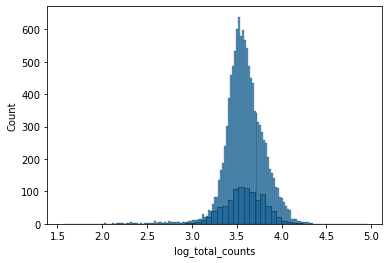

In [251]:
ax = sns.histplot(x = np.log10(lognorm(0.52360773, 0.0, 3867.9648).rvs(1000)))
sns.histplot(x = rna_data.obs.log_total_counts)
#ax.set(xscale = 'log')

In [125]:
rna_frankendata, atac_frankendata = r

In [126]:
rna_frankendata.layers['counts'] = rna_frankendata.X.copy()
atac_frankendata.layers['counts'] = atac_frankendata.X.copy()

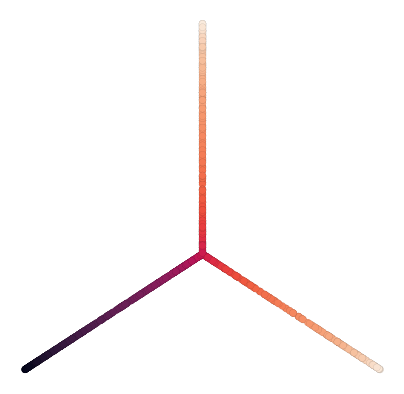

In [127]:
fig, ax = plt.subplots(1,1,figsize=(7,7))
sns.scatterplot(x = r[0].obsm['simplex'][:,0], y = r[0].obsm['simplex'][:,1],
                hue=r[0].obs.pseudotime, s= 50, ax = ax, legend=False,
               palette='rocket', edgecolor = 'black', linewidth = 0.05)
plt.axis('off')
plt.show()

In [2]:
rna_frankendata = anndata.read_h5ad('data/benchmarking/testset1.h5ad')
atac_frankendata = anndata.read_h5ad('data/benchmarking/testset2.h5ad')

In [3]:
sc.pp.normalize_total(rna_frankendata, target_sum=1e4)
sc.pp.log1p(rna_frankendata)

sc.pp.highly_variable_genes(rna_frankendata)
sc.tl.pca(rna_frankendata)

sc.pl.embedding(rna_frankendata, color = 'pseudotime', basis = 'X_pca',
               components=('1,2','2,3'), size=25)

rna_frankendata.write_h5ad('data/benchmarking/testset1.h5ad')
atac_frankendata.write_h5ad('data/benchmarking/testset2.h5ad')

INFO:mira.adata_interface.topic_model:Predicting expression from genes from col: highly_variable
INFO:mira.adata_interface.topic_model:Using highly-variable genes from col: highly_variable


Learning rate range test:   0%|          | 0/78 [00:00<?, ?it/s]

INFO:mira.topic_model.base:Set learning rates to: (0.0030003079350162404, 0.33461718723166356)
INFO:mira.topic_model.base:Set learning rates to: (0.022169443645901777, 0.33461718723166356)


<AxesSubplot:xlabel='Learning Rate', ylabel='Loss'>

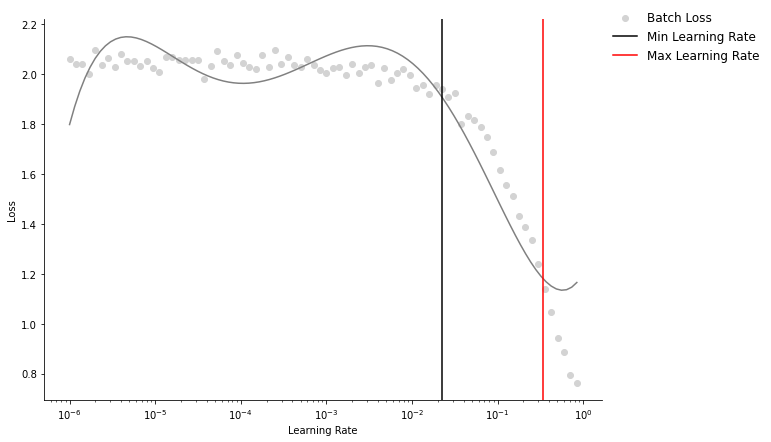

In [254]:
np.random.seed(2556)
rna_frankendata = rna_frankendata[np.random.permutation(len(rna_frankendata))]

rna_model = mira.topics.ExpressionTopicModel(
    endogenous_key= 'highly_variable',
    exogenous_key= 'highly_variable',
    counts_layer='counts',
    beta=0.91,
    batch_size=128,
    seed = 2556,
    encoder_dropout=0.01,
    num_topics = 5,
    kl_strategy='cyclic',
)

rna_model.get_learning_rate_bounds(rna_frankendata, num_epochs=10, eval_every=1)

rna_model.trim_learning_rate_bounds(2,0.5)
rna_model.plot_learning_rate_bounds()

In [ ]:
rna_model.fit(rna_frankendata)

rna_model.predict(rna_frankendata)

In [314]:
rna_model.get_umap_features(rna_frankendata, box_cox=0.9)

INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm
INFO:mira.adata_interface.core:Added key to obsm: X_umap_features


In [315]:
sc.pp.neighbors(rna_frankendata, use_rep='X_umap_features', metric='manhattan', key_added='topic_model')
sc.tl.umap(rna_frankendata, min_dist = 0.1, neighbors_key='topic_model', negative_sample_rate=1)

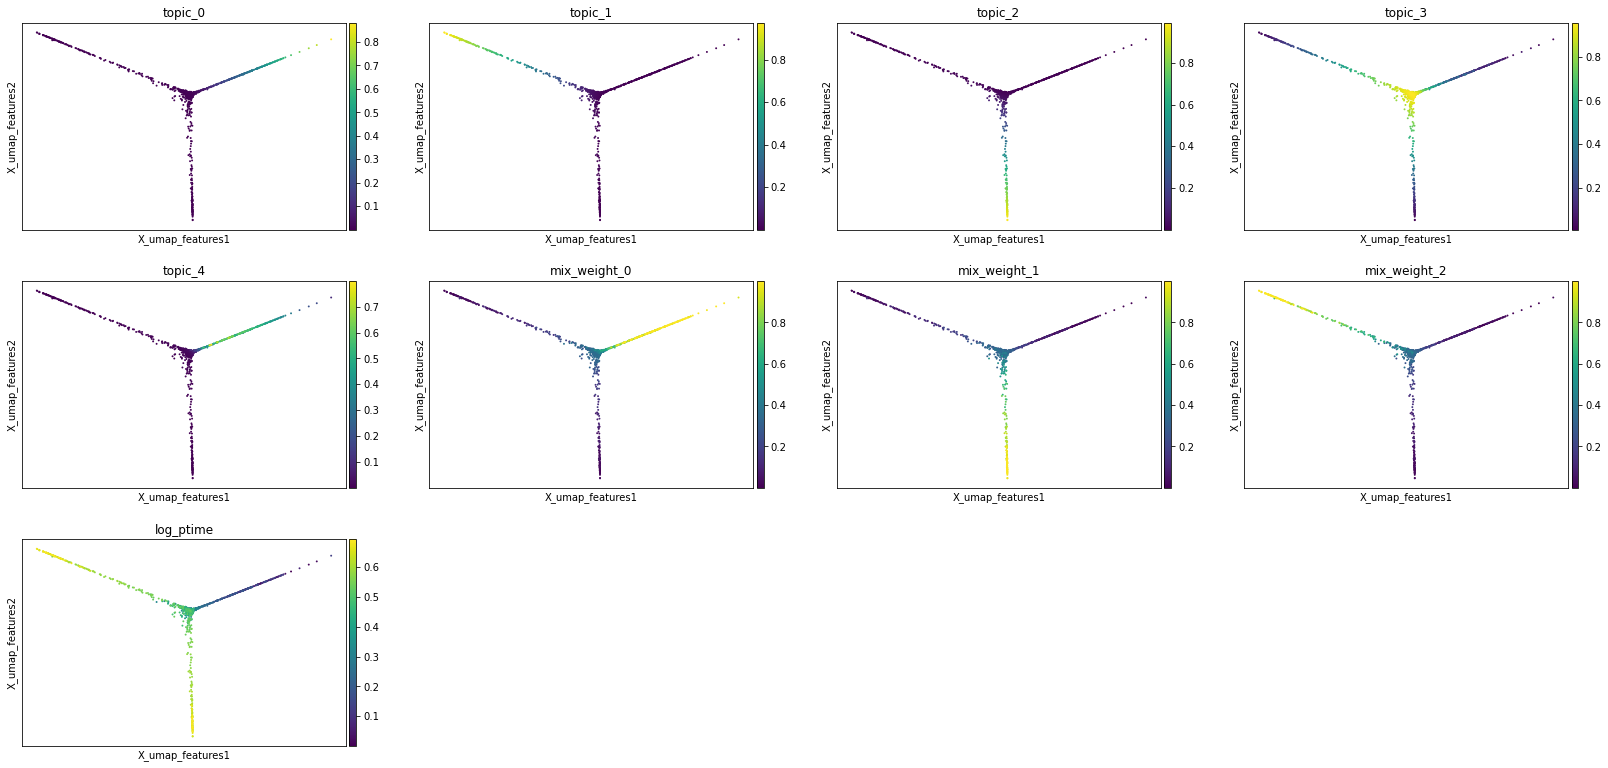

In [316]:
rna_frankendata.obs['log_ptime'] = np.log(rna_frankendata.obs.pseudotime + 1)

sc.pl.embedding(rna_frankendata, color = list(rna_model.topic_cols) + ['mix_weight_' + str(i) for i in range(3)] + ['log_ptime'],
          basis = 'X_umap_features', size = 15)

<AxesSubplot:xlabel='pseudotime', ylabel='mix_weight_1'>

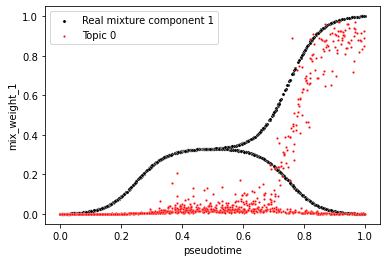

In [317]:
sns.scatterplot(data = rna_frankendata.obs, x = 'pseudotime', y = 'mix_weight_1', s = 10, color = 'black',
               label = 'Real mixture component 1')
sns.scatterplot(data = rna_frankendata.obs, x = 'pseudotime', y = 'topic_1', s= 5, color = 'red',
               label = 'Topic 0')

### Pseudotime

In [318]:
mira.time.get_connected_components(rna_frankendata, key = 'topic_model_connectivities')

#sc.pp.neighbors(rna_frankendata, use_rep='X_umap_features', metric='manhattan', key_added='topic_model')

mira.time.get_transport_map(rna_frankendata, diffmap_distances_key = 'topic_model_distances', 
                           diffmap_coordinates_key='X_umap_features', 
                            start_cell = int(rna_frankendata.obs.pseudotime.argmin()))

INFO:mira.pseudotime.pseudotime:Found 1 components of KNN graph.
INFO:mira.adata_interface.core:Added cols to obs: mira_connected_components
INFO:mira.pseudotime.pseudotime:Calculating inter-cell distances ...
INFO:root:Using 1 core. Speed this up by allocating more n_jobs.


Calculating pseudotime:   0%|          | 0/24875 [00:00<?, ?it/s]

INFO:mira.pseudotime.pseudotime:Calculating transport map ...
INFO:mira.adata_interface.pseudotime:Added key to obs: mira_pseudotime
INFO:mira.adata_interface.pseudotime:Added key to obsp: transport_map
INFO:mira.adata_interface.pseudotime:Added key to uns: start_cell


/Users/alynch/opt/miniconda3/envs/mirarep/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'mira_connected_components' as categorical


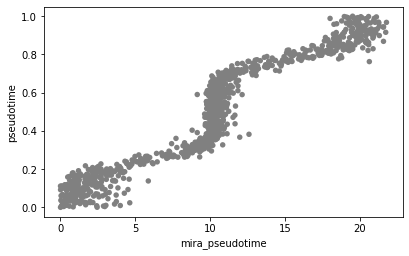

In [319]:
sc.pl.scatter(rna_frankendata, x = 'mira_pseudotime', y = 'pseudotime')

In [320]:
from sklearn.preprocessing import minmax_scale

In [321]:
rna_frankendata.obs['diff_pseudotime'] = minmax_scale(rna_frankendata.obs.mira_pseudotime)- rna_frankendata.obs.pseudotime

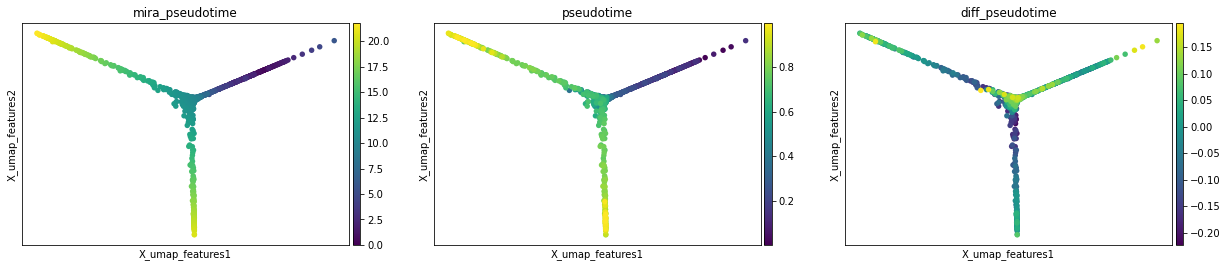

In [322]:
sc.pl.embedding(rna_frankendata, color = ['mira_pseudotime','pseudotime','diff_pseudotime'],
               basis = 'X_umap_features')

In [323]:
mira.time.get_branch_probabilities(rna_frankendata, 
            terminal_cells={'A' : int(rna_frankendata.obs.mix_weight_1.argmax()),
                           'B' : int(rna_frankendata.obs.mix_weight_2.argmax())})

INFO:mira.pseudotime.pseudotime:Simulating random walks ...
INFO:mira.adata_interface.pseudotime:Added key to obsm: branch_probs
INFO:mira.adata_interface.pseudotime:Added key to uns: lineage_names
INFO:mira.adata_interface.core:Added cols to obs: A_prob
INFO:mira.adata_interface.core:Added cols to obs: B_prob
INFO:mira.adata_interface.core:Added cols to obs: differentiation_entropy


INFO:mira.adata_interface.pseudotime:Added key to obs: tree_states
INFO:mira.adata_interface.pseudotime:Added key to uns: tree_state_names
INFO:mira.adata_interface.pseudotime:Added key to uns: connectivities_tree
/Users/alynch/opt/miniconda3/envs/mirarep/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'tree_states' as categorical


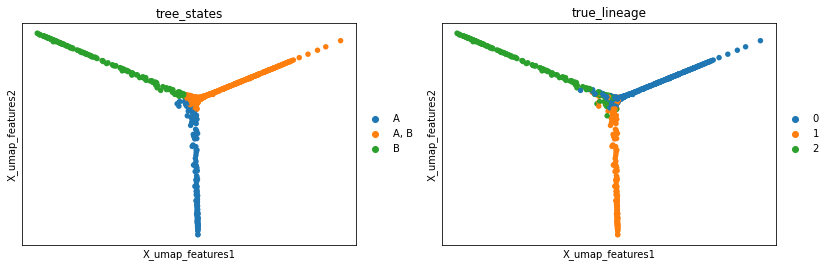

In [356]:
mira.time.get_tree_structure(rna_frankendata, threshold=0.4)
sc.pl.embedding(rna_frankendata, color = ['tree_states','true_lineage'], basis = 'X_umap_features',
               components=('1,2'))

/Users/alynch/opt/miniconda3/envs/mirarep/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'true_lineage' as categorical


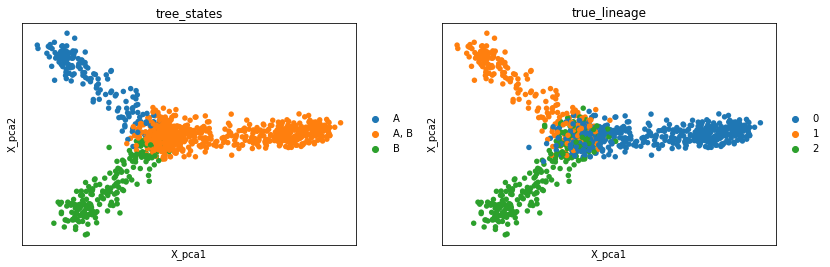

In [357]:
rna_frankendata.obs['true_lineage'] = rna_frankendata.obsm['mixing_weights'].argmax(-1).astype(str)

sc.pl.embedding(rna_frankendata, color = ['tree_states','true_lineage'], basis = 'X_pca')

<AxesSubplot:xlabel='tree_states', ylabel='count'>

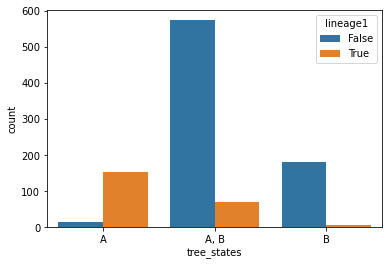

In [360]:
sns.countplot(data = rna_frankendata.obs, x= 'tree_states', hue = 'lineage1')

<AxesSubplot:xlabel='true_lineage', ylabel='count'>

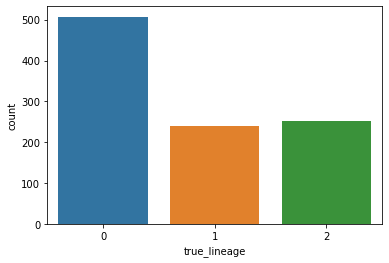

In [362]:
sns.countplot(data = rna_frankendata.obs, x = 'true_lineage')

# PCA

In [207]:
sc.pp.filter_genes(atac_frankendata, min_cells=10)

In [208]:
atac_frankendata.layers['binary'] = atac_frankendata.X.astype(bool).astype(int).copy()

In [138]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline

lsi = Pipeline([
    ('tfidf', TfidfTransformer()), 
    ('svd', TruncatedSVD(n_components=5))
])

In [210]:
atac_frankendata.obsm['X_lsi'] = lsi.fit_transform(atac_frankendata.layers['binary'])

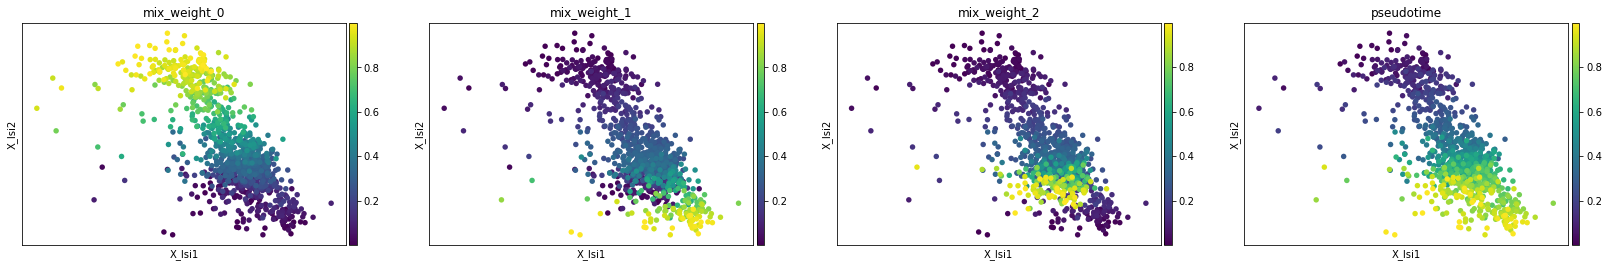

In [212]:
sc.pl.embedding(atac_frankendata, color = ['mix_weight_' + str(i) for i in range(3)] + ['pseudotime'],
               basis = 'X_lsi', components=('1,2'))

In [214]:
lsi.steps[1][1].explained_variance_ratio_

array([0.00023475, 0.0042497 , 0.00242841, 0.00212379, 0.00185355])

In [107]:
atac_model = mira.topics.AccessibilityTopicModel(
    counts_layer='counts',
    kl_strategy='cyclic',
    beta=0.93,
    batch_size=64,
)

atac_model.get_learning_rate_bounds(atac_data, num_epochs = 5)

Learning rate range test:   0%|          | 0/91 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
atac_model.trim_learning_rate_bounds(5,1)
atac_model.plot_learning_rate_bounds(5,1)